# MU5EEB13: Sensori-motor behavior, motor learning, haptic function

## TP1 Forearm movements and LQR model

**Organization and evaluation**:

The evaluation will be based on 8 labs (4 with *Olivier Sigaud*, 3 with *Julien Gori*, 1 with *David Gueorguiev*) and a journal club oral presentation (with *Malika Auvray* and *Emmanuel Guigon*). The 9 marks (on 100) will be combined to give the final mark (on 100) according to 0.1 x (Lab1 + .. + Lab8) + 0.2 x journal club.

**Teachers and lecturers**: 
- Olivier Sigaud - mail: olivier.sigaud@sorbonne-universite.fr
- David Gueorguiev - mail: gueorguiev@isir.upmc.fr
- Julien Gori - mail: gori@isir.upmc.fr
- Malika Auvray - mail: malika.auvray@sorbonne-universite.fr
- Emmanuel Guigon - mail: emmanuel.guigon@sorbonne-universite.fr

**Student**: William WU - mail: william.wu@etu.sorbonne-universite.fr

___




In this lab, you are going to model human movement data using a computational model from
optimal control theory known as the Linear Quadratic Regulator (LQR). You will use data from an
experiment conducted in 2011 where participants were instructed to aim towards a very thin line,
adopting 5 different strategies, from very fast to very precise. This experiment captures the so-called
speed-accuracy tradeoff of human movement, where usually more precise movements will be slower.
This lab has 4 parts: the first part is about basic manipulations of the data, and visualizing that
data. The second and third part are ”courses”, and we will treat them together. The fourth part is
about applying what you just learned in the course.

#### Importing libraries

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

---

## 1. Visualizing and pre-processing the data

#### Task 1: Load movement data

In [2]:
def load_movement_data(file_path):

    # Initialize lists to store our movement data
    movements = []  # This will store each movement as a separate list of (time, position) pairs
    current_movement = []  # Temporary list for the current movement being read
    
    # The file is a csv file with ; as separator
    with open(file_path, "r") as _file:  # open file in read ( ’r ’) mode
        for line in _file:  # iterate over each line

            # Clean the line by stripping whitespace
            cleaned_line = line.strip()
            
            # Skip empty lines and comment lines
            if not cleaned_line or cleaned_line.startswith('####'):
                continue
                
            # Check for movement header
            if cleaned_line.startswith('Movement number'):
                # If we were collecting a movement, save it before starting a new one
                if current_movement:
                    movements.append(current_movement)
                    current_movement = []  # Start a new movement
                continue  # Skip the header line
                
            # Process data lines (time;position pairs)
            values = cleaned_line.split(';')    # to get values from line, use line . split ( ’; ’)

            # Convert to floats and store as tuple
            if len(values) == 2:
                try:
                    time = float(values[0])
                    position = float(values[1])
                    current_movement.append((time, position))
                except ValueError:
                    print(f"Warning: Could not convert line to numbers: {cleaned_line}")
    
    # Add the last movement if there is one
    if current_movement:
        movements.append(current_movement)

    # Display what we loaded
    print(f"Number of movements loaded: {len(movements)} \n")
    for i, movement in enumerate(movements):
        print(f"Movement {i+1}: {len(movement)} data points")
        print(f"  Time range: {movement[0][0]:.4f} to {movement[-1][0]:.4f}")
        print(f"  Position range: {movement[0][1]:.1f} to {movement[-1][1]:.1f}")
        # Show first few data points from first movement as example
        print(f"  First 3 points: {movement[:3]}")
        print()

    return movements

path_1 = "data/two_movements.csv"
movements_data = load_movement_data(path_1)

Number of movements loaded: 2 

Movement 1: 378 data points
  Time range: 2.3712 to 6.3752
  Position range: 4153.0 to 18793.0
  First 3 points: [(2.3712, 4153.0), (2.3873, 4153.0), (2.3912, 4155.0)]

Movement 2: 224 data points
  Time range: 7.7872 to 10.1313
  Position range: 4163.0 to 18980.0
  First 3 points: [(7.7872, 4163.0), (7.7912, 4160.0), (7.8072, 4161.0)]



#### Task 2: Resample data

In [3]:
def resample_data(movements, dt=0.01):

    resampled_data = []
    
    for i, movement in enumerate(movements):
        # Extract original time and position arrays
        original_time = np.array([point[0] for point in movement])
        original_position = np.array([point[1] for point in movement])
        
        # Create new equally spaced time array
        start_time = original_time[0]
        end_time = original_time[-1]
        resampled_time = np.arange(start_time, end_time + dt, dt)
        
        # Use linear interpolation to get position values at new time points
        resampled_position = np.interp(resampled_time, original_time, original_position)
        
        # Store the resampled data
        resampled_data.append((resampled_time, resampled_position))
        
        # Display information about resampled movement
        print(f"Movement {i+1}:")
        print(f"  Original points: {len(movement)}")
        print(f"  Resampled points: {len(resampled_time)}")
        print(f"  Resampled time range: {resampled_time[0]:.4f} to {resampled_time[-1]:.4f}")
        print(f"  Time step: {resampled_time[1] - resampled_time[0]:.4f}s")
        print(f"  First 3 resampled points:")
        for j in range(min(3, len(resampled_time))):
            print(f"    t={resampled_time[j]:.4f}s, pos={resampled_position[j]:.1f}")
        print()
    
    return resampled_data

resampled_data = resample_data(movements_data, dt=0.01)

Movement 1:
  Original points: 378
  Resampled points: 402
  Resampled time range: 2.3712 to 6.3812
  Time step: 0.0100s
  First 3 resampled points:
    t=2.3712s, pos=4153.0
    t=2.3812s, pos=4153.0
    t=2.3912s, pos=4155.0

Movement 2:
  Original points: 224
  Resampled points: 236
  Resampled time range: 7.7872 to 10.1372
  Time step: 0.0100s
  First 3 resampled points:
    t=7.7872s, pos=4163.0
    t=7.7972s, pos=4160.4
    t=7.8072s, pos=4161.0



#### Task 3: Average trajectory

In [4]:
def average_trajectory(resampled_data):

    # Extract just the position arrays from all movements
    position_arrays = [position for _, position in resampled_data]
    
    # Find the maximum length among all movements
    max_length = max(len(pos) for pos in position_arrays)
    
    # Extend all position arrays to the same length using the last value
    extended_positions = []
    for pos in position_arrays:
        if len(pos) < max_length:
            # Create extended array by repeating the last value
            extended_pos = np.zeros(max_length)
            extended_pos[:len(pos)] = pos
            extended_pos[len(pos):] = pos[-1]  # Fill with last value
            extended_positions.append(extended_pos)
        else:
            extended_positions.append(pos)
    
    # Convert to numpy array for easy averaging
    position_matrix = np.array(extended_positions)
    
    # Compute the average across movements
    average_position = np.mean(position_matrix, axis=0)
    
    # Display information about the averaging
    print(f"Number of movements to average: {len(resampled_data)}")
    print(f"Original movement lengths: {[len(pos) for pos in position_arrays]}")
    print(f"Extended to common length: {max_length}")
    print(f"First 5 average position values: {average_position[:5]}")
    print(f"Last 5 average position values: {average_position[-5:]}")
    
    return average_position

average_position = average_trajectory(resampled_data)

Number of movements to average: 2
Original movement lengths: [402, 236]
Extended to common length: 402
First 5 average position values: [4158.     4156.6875 4158.     4161.75   4175.5   ]
Last 5 average position values: [18970.4375 18957.625  18908.8125 18892.875  18886.5   ]


#### Task 4: Load extended data

DATASET LOADED:
Number of conditions: 5
Conditions and number of trajectories per condition:
  3: 86 trajectories
    Shape of each trajectory: (289,)
  4: 76 trajectories
    Shape of each trajectory: (312,)
  2: 77 trajectories
    Shape of each trajectory: (140,)
  1: 80 trajectories
    Shape of each trajectory: (68,)
  5: 72 trajectories
    Shape of each trajectory: (478,)

DATASET DESCRIPTION:

Condition: 3
  Number of trajectories: 86
  Position range: -0.2 to 167.6
  Mean position: 139.8
  Std position: 30.3
  Average trajectory length: 289 samples
  Average start position: 0.0
  Average end position: 148.1

Condition: 4
  Number of trajectories: 76
  Position range: -0.1 to 170.2
  Mean position: 139.7
  Std position: 30.2
  Average trajectory length: 312 samples
  Average start position: 0.0
  Average end position: 148.0

Condition: 2
  Number of trajectories: 77
  Position range: -0.3 to 170.1
  Mean position: 134.2
  Std position: 39.2
  Average trajectory length: 140 samp

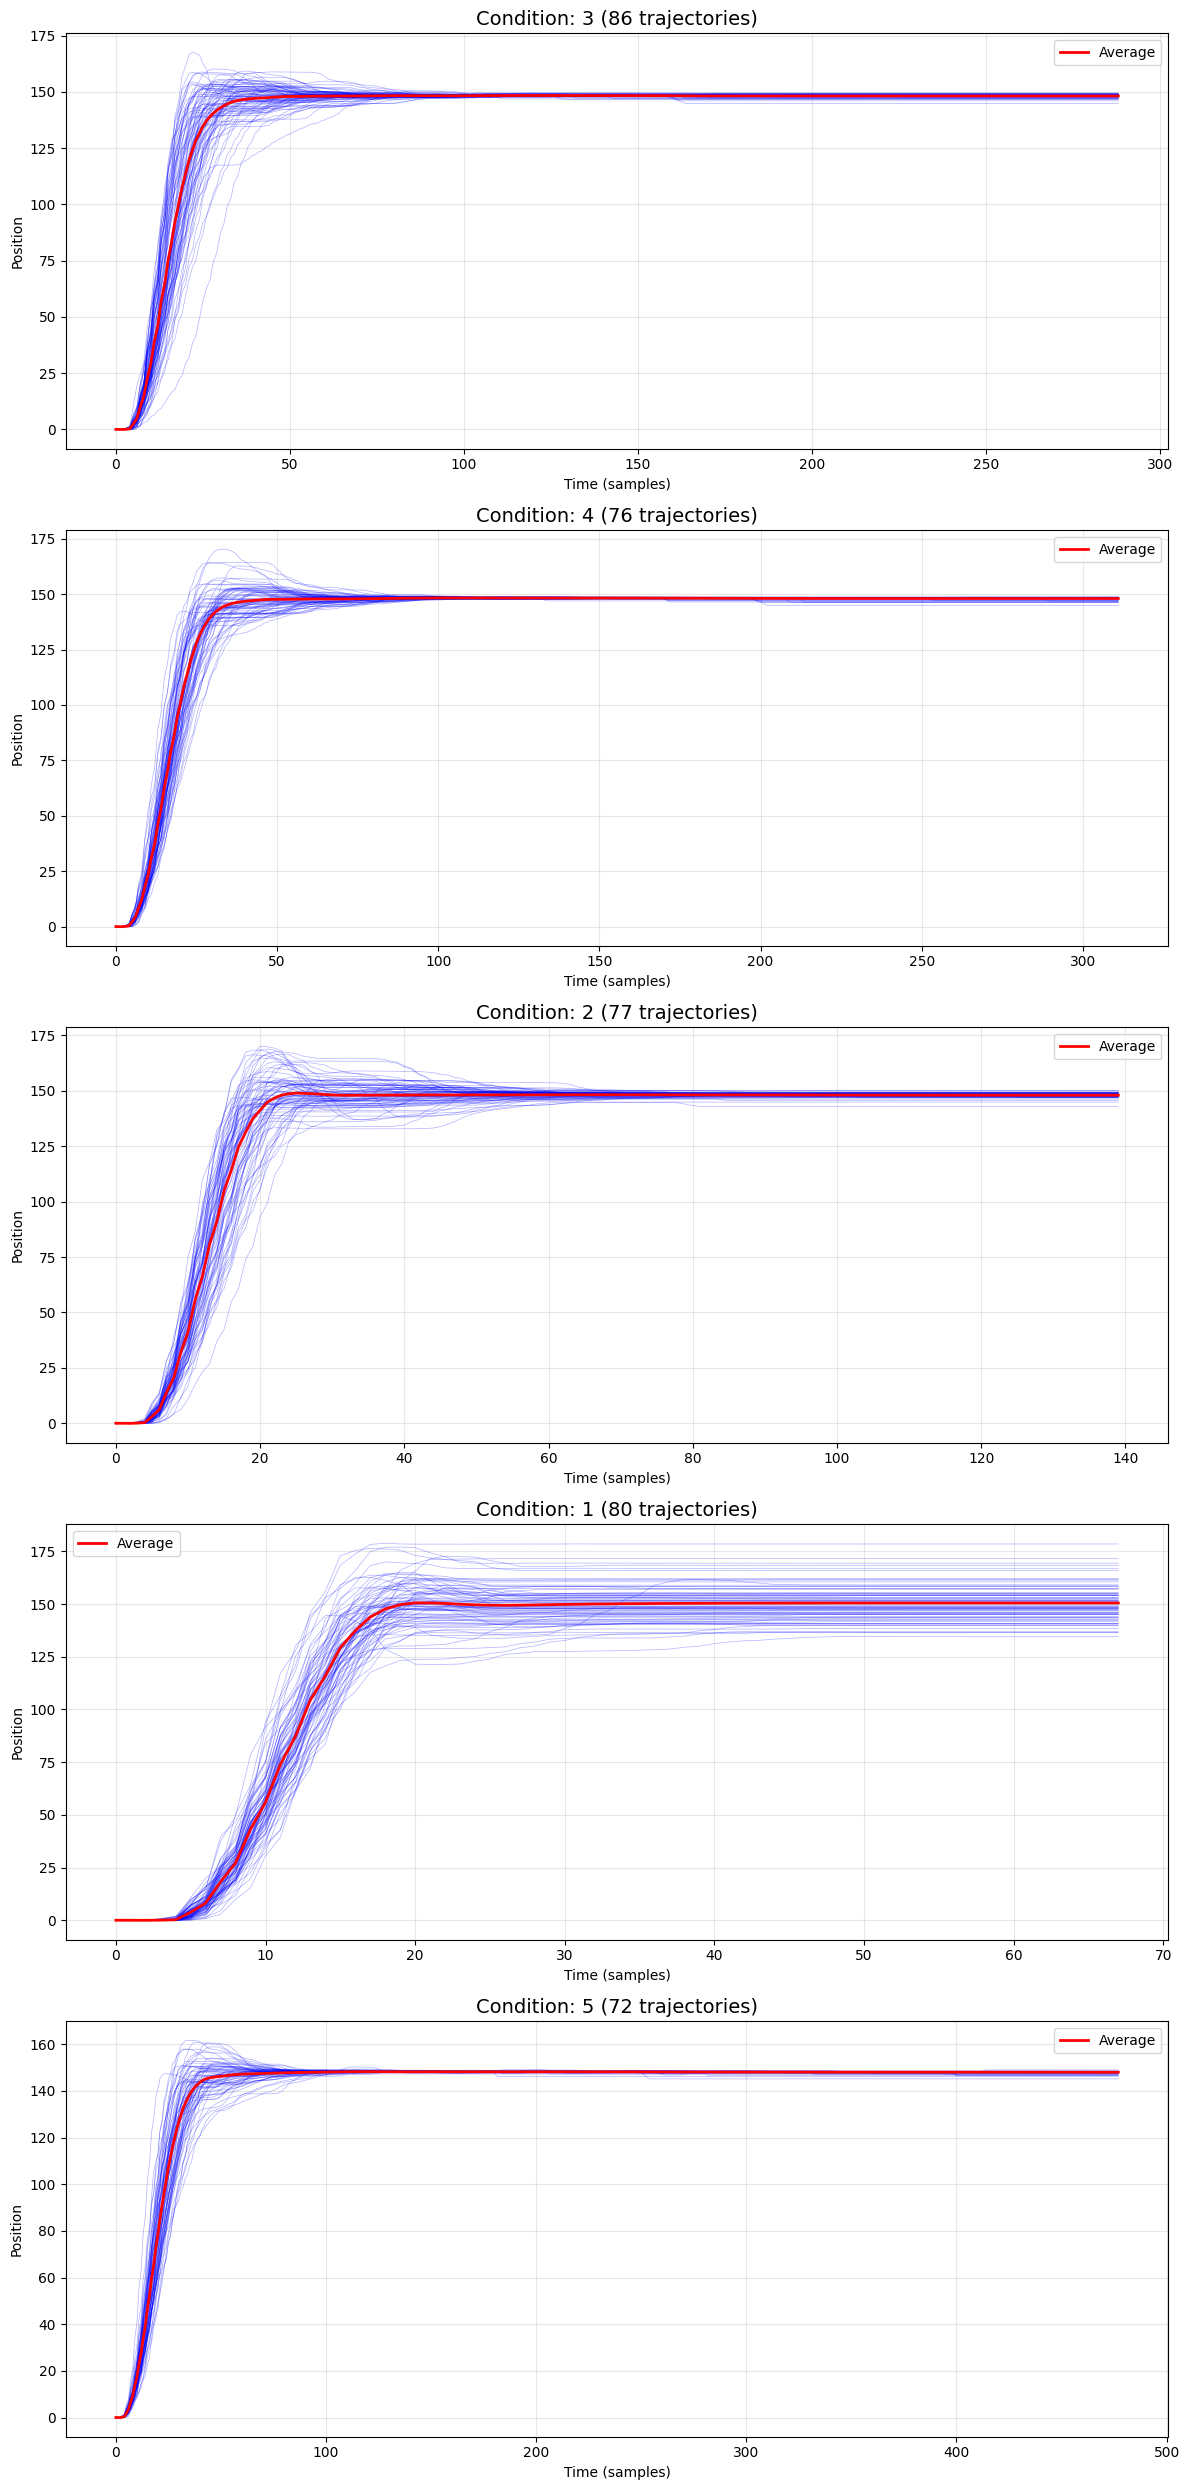

In [5]:
def load_extended_data(file_path):
    
    with open(file_path, "rb") as handle:
        dataset = pickle.load(handle)
    
    print("DATASET LOADED:")
    print(f"Number of conditions: {len(dataset)}")
    print("Conditions and number of trajectories per condition:")
    for condition, trajectories in dataset.items():
        print(f"  {condition}: {len(trajectories)} trajectories")
        if len(trajectories) > 0:
            print(f"    Shape of each trajectory: {trajectories[0].shape}")
    
    return dataset

def compute_average_trajectory(trajectories):
    
    # Find the maximum length among all trajectories
    max_length = max(len(traj) for traj in trajectories)
    
    # Extend all trajectories to the same maximum length using the last value
    extended_trajectories = []
    for traj in trajectories:
        if len(traj) < max_length:
            # Create extended array by padding with the last value
            extended_traj = np.zeros(max_length)
            extended_traj[:len(traj)] = traj
            extended_traj[len(traj):] = traj[-1]  # Fill with last value
            extended_trajectories.append(extended_traj)
        else:
            extended_trajectories.append(traj)
    
    # Convert to numpy array and compute mean
    trajectory_matrix = np.array(extended_trajectories)
    average_trajectory = np.mean(trajectory_matrix, axis=0)
    
    return average_trajectory

def describe_dataset(dataset):
    
    print("\nDATASET DESCRIPTION:")
    print("=" * 50)
    
    for condition, trajectories in dataset.items():
        print(f"\nCondition: {condition}")
        print(f"  Number of trajectories: {len(trajectories)}")
        
        if len(trajectories) > 0:
            # Use original trajectories directly
            position_arrays = trajectories
            
            # Compute statistics for position values
            all_positions = np.concatenate(position_arrays)
            
            # Calculate lengths and approximate durations (assuming 10ms sampling)
            lengths = [len(traj) for traj in position_arrays]
            
            #print(f"  Trajectory lengths: {min(lengths)} to {max(lengths)} samples")
            print(f"  Position range: {np.min(all_positions):.1f} to {np.max(all_positions):.1f}")
            print(f"  Mean position: {np.mean(all_positions):.1f}")
            print(f"  Std position: {np.std(all_positions):.1f}")
            
            # Average trajectory info
            avg_trajectory = compute_average_trajectory(trajectories)
            print(f"  Average trajectory length: {len(avg_trajectory)} samples")
            print(f"  Average start position: {avg_trajectory[0]:.1f}")
            print(f"  Average end position: {avg_trajectory[-1]:.1f}")

def visualize_dataset(dataset):
    
    n_conditions = len(dataset)
    
    # Create one figure with multiple subplots arranged vertically
    fig, axs = plt.subplots(nrows=n_conditions, ncols=1, figsize=(12, 5*n_conditions))
    
    # Handle the case when there's only one condition
    if n_conditions == 1:
        axs = [axs]
    
    # Plot each condition in its own subplot
    for idx, (condition, trajectories) in enumerate(dataset.items()):
        ax = axs[idx]
        
        # Plot individual trajectories (light lines)
        for i, trajectory in enumerate(trajectories):
            alpha = 0.3 if len(trajectories) > 1 else 1.0  # More transparent if many trajectories
            ax.plot(trajectory, alpha=alpha, linewidth=0.5, color='blue')
        
        # Compute and plot average trajectory
        avg_trajectory = compute_average_trajectory(trajectories)
        ax.plot(avg_trajectory, color='red', linewidth=2, label='Average')
        
        # Customize plot
        ax.set_title(f'Condition: {condition} ({len(trajectories)} trajectories)', fontsize=14)
        ax.set_xlabel('Time (samples)')
        ax.set_ylabel('Position')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Load the dataset
path_2 = "data/extracted_data_extended"
dataset = load_extended_data(path_2)

# Describe the dataset
describe_dataset(dataset)

# Visualize the dataset
visualize_dataset(dataset)

#### Task 5: Study of all average trajectories

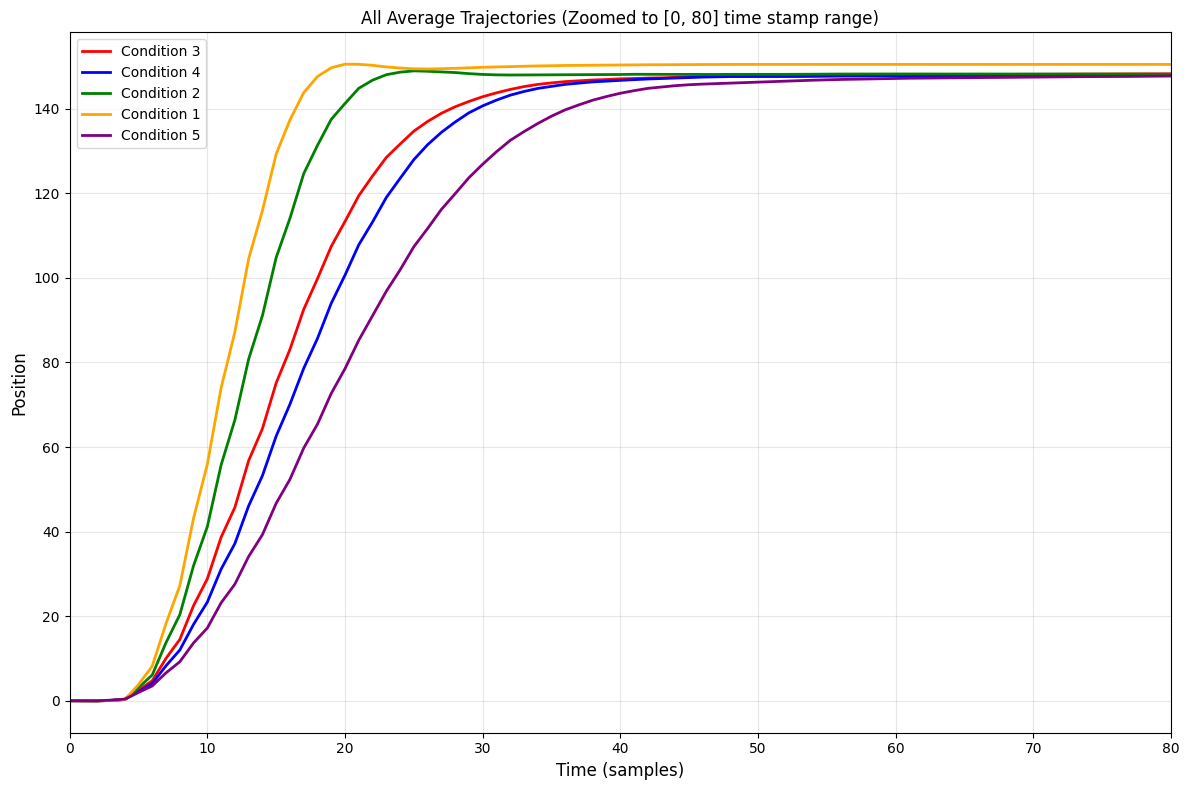

In [6]:
# Plot all average trajectories on the same graph (all extended to longest average)
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# First compute all average trajectories and find the maximum length
avg_trajectories = []
for condition, trajectories in dataset.items():
    avg_traj = compute_average_trajectory(trajectories)
    avg_trajectories.append(avg_traj)

max_length = max(len(avg_traj) for avg_traj in avg_trajectories)

# Now plot all averages extended to the maximum length
for idx, (condition, trajectories) in enumerate(dataset.items()):
    # Compute average trajectory
    avg_trajectory = compute_average_trajectory(trajectories)
    
    # Extend to maximum length if needed
    if len(avg_trajectory) < max_length:
        extended_avg = np.zeros(max_length)
        extended_avg[:len(avg_trajectory)] = avg_trajectory
        extended_avg[len(avg_trajectory):] = avg_trajectory[-1]
        avg_trajectory = extended_avg
    
    # Plot extended average trajectory
    plt.plot(avg_trajectory, color=colors[idx % len(colors)], linewidth=2, label=f'Condition {condition}')

plt.title('All Average Trajectories (Zoomed to [0, 80] time stamp range)')
plt.xlabel('Time (samples)', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Zoom to time stamp [0, 80]
plt.xlim(0, 80)

plt.tight_layout()
plt.show()

In these different average trajectories we can see that:
- Condition 1 (yellow curve) has a little oscillations, its priority and aim are to reach a position the fastest way possible, which probably made it quite unstable. So is the Condition 2 (green curve) but slightly less both fast and unstable.
- Condition 5 is the slowest one, its priority was probably to never get the overshoot (with the unstability).
- In the end, the others were more or less some gradual progression between these two "extreme study case" with the 1st condition being the one a bit more unstable and the 5th one being the quite slower one.

---

## 2. Single-joint forearm dynamics

To describe forearm movements, we consider the simplified representation in Fig. 1 for flat movements
produced. 

<img src="forearm_model.png" alt="Forearm Model" width="500">

We consider that the effect of the neural system controlling the movement is to apply a torque $\tau$ around the elbow joint. We also sum up the effects of the various internal and external frictions as a speed-dependent braking torque ($\tau_{break} = b \cdot \dot{\theta)}$. Then, using Newton’s second law for rotations, we have:

\begin{align}
I\ddot{\theta} &= \tau - \tau_{\text{break}}\\
I\ddot{\theta} &+ b\dot{\theta} = \tau
\end{align}

with 
- Moment of Inertia: $I = 0.25 \  kg.m ^{2}$
- Effective viscosity: $b = 0.2 \ kg.m ^{2}.s ^{-1}$
- Torque $\tau$ in $N.m$ 

### 2.1 Matrix form ($\dot{x} = Fx + Gu$)

To get the following matrix form $\dot{x} = Fx + Gu$ with $x = \begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix}$ and $u = \tau$, we put Newton's second law in the equation. 

This form is useful because it is the general form of a linear system, for which many results exist. To determine it, we first have to identify $\dot{\theta}$ and $\ddot{\theta}$. We obtain these two following equations:

\begin{align}
θ̇ =& 1 · θ̇  \\
θ̈ =& (1/I)(τ − b θ̇)
\end{align}

$$
\text{We want to get this form:} \qquad \dot{x} \; = F \cdot x + Gu 
$$

$$
\Longrightarrow \qquad
\begin{bmatrix} 
    \dot{\theta} \\ \ddot{\theta}
\end{bmatrix} =
\begin{bmatrix}
    a & b \\ c & d
\end{bmatrix} \cdot
\begin{bmatrix}
    \theta \\ \dot{\theta}
\end{bmatrix} +
\begin{bmatrix}
    e \\ f
\end{bmatrix}
\tau
$$

$$ \text{By identification of each terms with the equations (1) and (2), we get:} $$

$$
\Longrightarrow \qquad
\begin{bmatrix} 
    \dot{\theta} \\ \ddot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
    0 & 1 \\ 0 & -b/I
\end{bmatrix}
\cdot
\begin{bmatrix}
    \theta \\ \dot{\theta}
\end{bmatrix}
+
\begin{bmatrix}
    0 \\ 1/I
\end{bmatrix}
\tau
$$

$$
\text{with} \quad
F =
\begin{bmatrix}
    0 & 1 \\ 0 & -b/I
\end{bmatrix}
\quad \text{and} \quad
G = 
\begin{bmatrix}
    0 \\ 1/I
\end{bmatrix}
$$

### 2.2 Euler forward approximation to get the discrete time

$$
\text{Euler approximation gives us:} \qquad \dot{x} = \frac{x[(k+1)T]−x[kT]}{T}
$$

$$
\text{We want to get this form:} \qquad x[(k + 1)T] = Ax[kT] + Bu[kT]
$$

Using the previous form $\dot{x} = Fx + Gu$ :

\begin{align*}
\Longrightarrow \quad \frac{x[(k+1)T]−x[kT]}{T} & = \ Fx[kT] + Gu[kT] \\
\Longrightarrow \quad x[(k+1)T]−x[kT] & = \ T (Fx[kT] + Gu[kT]) \\
\Longrightarrow \quad x[(k+1)T]−x[kT] & = \ TFx[kT] + TGu[kT]
\end{align*}

\begin{align*}
\Longrightarrow \quad x[(k+1)T] & =  (I+TF) \cdot x[kT] + TG \cdot u[kT] \\
\Longleftrightarrow \quad x[(k+1)T] & = \qquad A \quad \cdot x[kT] + \; B \cdot u[kT]
\end{align*}

$$
\text{with:} \quad \ A = I+TF \quad \text{and} \quad B = TG
$$

---

## 3. Linear Quadratic Regulator

We consider the discrete time system:

\begin{align}
x_{k+1} =& \ A x_k + B u_k \\
x_0 =& \ \text{given initial state}
\end{align}

We want to minimize the quadratic cost function:

$$
J(u_0, u_1,... \ , u_{N−1}) = \sum_{k=0}^{N-1}{\left( x_k^T \ Q \ x_k + u_k^T \ R \ u_k \right) + x_N^T \ Q_F \ x_N}
$$
$$
\text{with} \qquad Q \geq 0, Q_F \geq 0, R > 0
$$

### Dynamic Programming formulation

We can solve the previous optimization problem via dynamic programming (DP), where we define the value function $V_k(z)$ associated with state $z$ at timestep $k$:

$$
V_k(z) = \min_{u_k, ... \ , u_{N-1}} \sum_{j=k}^{N-1}{\left( x_j^T \ Q \ x_j + u_j^T \ R \ u_j \right) + x_N^T \ Q_F \ x_N}
$$

subject to $x_k = z$, $xè{k+1} = A x_k + B u_k$. This is just a version of $J$ that evaluates the remaining cost
from some time step $k$ if the current state is $z$. We want to express $J$ as a function of $V$